Checking Class Imbalance for each Class

Class Distribution:
Normal: 1342 images
Pneumonia: 3876 images
Total: 5218 images

Percentage Distribution:
Normal: 25.72%
Pneumonia: 74.28%


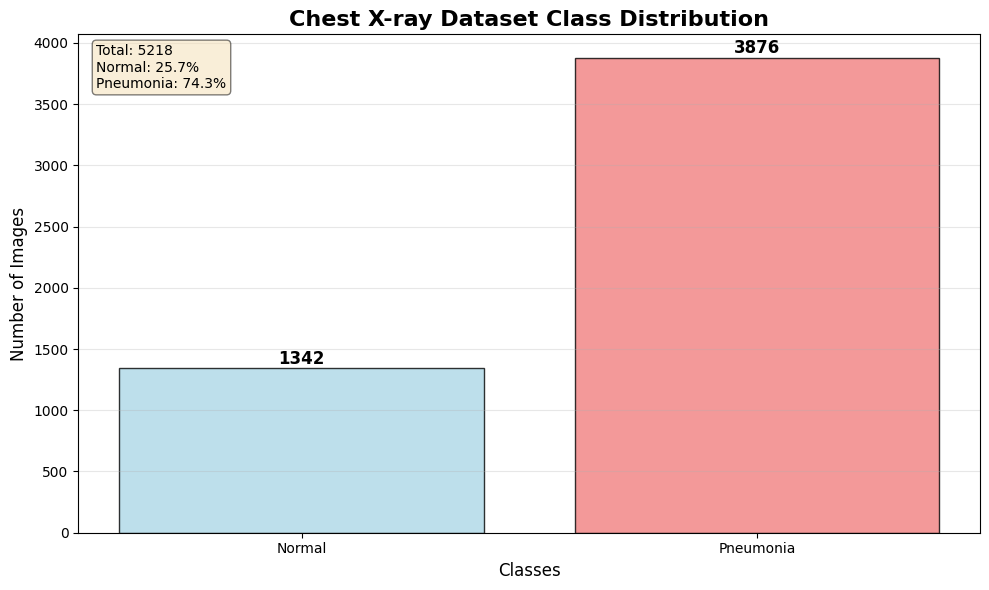


⚠️  Warning: Significant class imbalance detected!


In [1]:
import os
import matplotlib.pyplot as plt

# Define the paths to your dataset directories
normal_path = r"chest_xray/train/NORMAL"
pneumonia_path = r"chest_xray/train/PNEUMONIA"

# Count the number of images in each directory
normal_count = len([f for f in os.listdir(normal_path) if os.path.isfile(os.path.join(normal_path, f))])
pneumonia_count = len([f for f in os.listdir(pneumonia_path) if os.path.isfile(os.path.join(pneumonia_path, f))])

# Print the class distribution
print("Class Distribution:")
print(f"Normal: {normal_count} images")
print(f"Pneumonia: {pneumonia_count} images")
print(f"Total: {normal_count + pneumonia_count} images")

# Calculate percentages
total = normal_count + pneumonia_count
normal_percentage = (normal_count / total) * 100
pneumonia_percentage = (pneumonia_count / total) * 100

print(f"\nPercentage Distribution:")
print(f"Normal: {normal_percentage:.2f}%")
print(f"Pneumonia: {pneumonia_percentage:.2f}%")

# Create bar chart
classes = ['Normal', 'Pneumonia']
counts = [normal_count, pneumonia_count]
colors = ['lightblue', 'lightcoral']

plt.figure(figsize=(10, 6))
bars = plt.bar(classes, counts, color=colors, edgecolor='black', alpha=0.8)

# Add value labels on top of each bar
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             str(count), ha='center', va='bottom', fontsize=12, fontweight='bold')

# Customize the plot
plt.title('Chest X-ray Dataset Class Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Add text box with summary statistics
textstr = f'Total: {total}\nNormal: {normal_percentage:.1f}%\nPneumonia: {pneumonia_percentage:.1f}%'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

# Check for class imbalance
if min(normal_count, pneumonia_count) / max(normal_count, pneumonia_count) < 0.5:
    print("\n⚠️  Warning: Significant class imbalance detected!")
else:
    print("\n✓ Classes are relatively balanced")

Balancing the "Normal" class using image augmentation

In [6]:
import tensorflow as tf
from keras.src.legacy.preprocessing.image import ImageDataGenerator
import os
import numpy as np
from sklearn.utils import class_weight

# Define paths
train_dir = r"D:/ICIS/chest_xray/train"
normal_path = os.path.join(train_dir, "NORMAL")
pneumonia_path = os.path.join(train_dir, "PNEUMONIA")

# Count original images
normal_count = len([f for f in os.listdir(normal_path) if os.path.isfile(os.path.join(normal_path, f))])
pneumonia_count = len([f for f in os.listdir(pneumonia_path) if os.path.isfile(os.path.join(pneumonia_path, f))])

print(f"Original counts - Normal: {normal_count}, Pneumonia: {pneumonia_count}")

# Calculate how many augmented images we need to create
augmentation_factor = pneumonia_count // normal_count
print(f"Augmentation factor: {augmentation_factor}")

# Create augmented images for the Normal class
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to create and save augmented images
def augment_images(class_path, augmentation_factor):
    image_files = [f for f in os.listdir(class_path) 
                  if os.path.isfile(os.path.join(class_path, f)) and
                  f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
    
    for image_file in image_files:
        img_path = os.path.join(class_path, image_file)
        
        try:
            # Load image with verification
            img = Image.open(img_path)
            img.verify()  # Verify image integrity
            img = Image.open(img_path)  # Reopen for processing
            
            # Convert to array and reshape
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)
            
            # Generate augmented images
            i = 0
            for batch in datagen.flow(x, batch_size=1, 
                                     save_to_dir=class_path, 
                                     save_prefix='aug', 
                                     save_format='jpeg'):
                i += 1
                if i >= augmentation_factor:
                    break
                    
        except (IOError, SyntaxError, ValueError) as e:
            print(f"Skipping corrupted file {image_file}: {str(e)}")
            continue

# Create augmented images for the Normal class
print("Creating augmented images for Normal class...")
augment_images(normal_path, augmentation_factor)

# Count images after augmentation
normal_count_aug = len([f for f in os.listdir(normal_path) if os.path.isfile(os.path.join(normal_path, f))])
pneumonia_count_aug = len([f for f in os.listdir(pneumonia_path) if os.path.isfile(os.path.join(pneumonia_path, f))])

print(f"After augmentation - Normal: {normal_count_aug}, Pneumonia: {pneumonia_count_aug}")

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique([0, 1]),
    y=np.concatenate([np.zeros(normal_count_aug), np.ones(pneumonia_count_aug)])
)

class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class weights: {class_weights_dict}")

# Create data generators for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Create generators for each class
normal_generator = train_datagen.flow_from_directory(
    train_dir,
    classes=['NORMAL'],
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

pneumonia_generator = train_datagen.flow_from_directory(
    train_dir,
    classes=['PNEUMONIA'],
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

# Create balanced generator
def balanced_generator(generator1, generator2):
    while True:
        # Get batches from both generators
        batch1 = next(generator1)
        batch2 = next(generator2)
        
        # Combine the batches
        x = np.concatenate([batch1[0], batch2[0]])
        y = np.concatenate([batch1[1], batch2[1]])
        
        # Shuffle the combined batch
        indices = np.arange(x.shape[0])
        np.random.shuffle(indices)
        x = x[indices]
        y = y[indices]
        
        yield x, y

# Create the balanced generator
balanced_train_generator = balanced_generator(normal_generator, pneumonia_generator)

# Create validation generator
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

print("Data augmentation and balanced generator created successfully!")
print(f"Class weights to use in training: {class_weights_dict}")

Original counts - Normal: 1342, Pneumonia: 3876
Augmentation factor: 2
Creating augmented images for Normal class...
After augmentation - Normal: 3688, Pneumonia: 3876
Class weights: {0: np.float64(1.0254880694143167), 1: np.float64(0.9757481940144479)}
Found 2950 images belonging to 1 classes.
Found 3100 images belonging to 1 classes.
Found 1512 images belonging to 2 classes.
Data augmentation and balanced generator created successfully!
Class weights to use in training: {0: np.float64(1.0254880694143167), 1: np.float64(0.9757481940144479)}


Checking class imbalance

Class Distribution:
Normal: 3688 images
Pneumonia: 3876 images
Total: 7564 images

Percentage Distribution:
Normal: 48.76%
Pneumonia: 51.24%


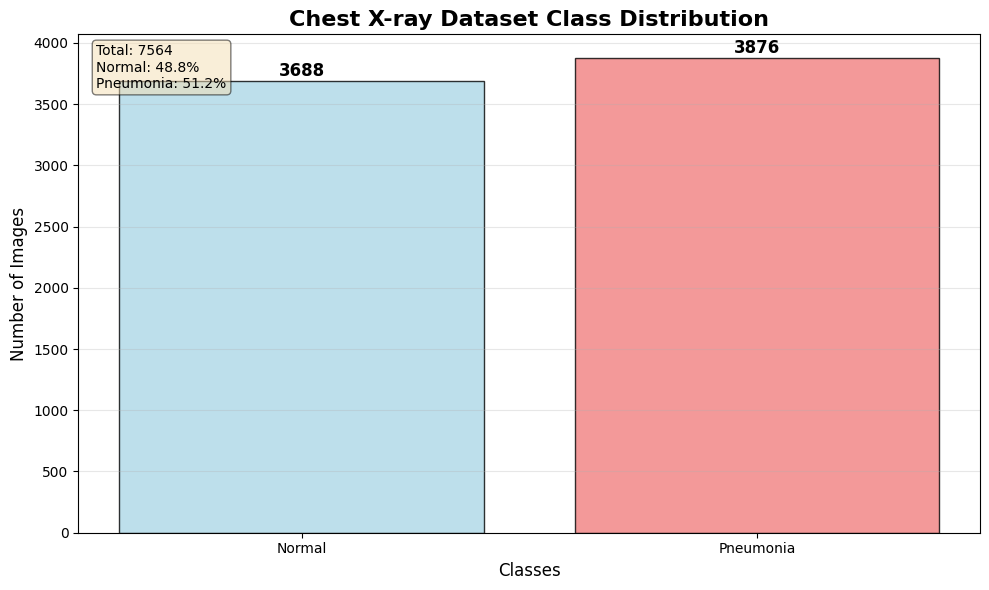


✓ Classes are relatively balanced


In [7]:
import os
import matplotlib.pyplot as plt

# Define the paths to your dataset directories
normal_path = r"chest_xray/train/NORMAL"
pneumonia_path = r"chest_xray/train/PNEUMONIA"

# Count the number of images in each directory
normal_count = len([f for f in os.listdir(normal_path) if os.path.isfile(os.path.join(normal_path, f))])
pneumonia_count = len([f for f in os.listdir(pneumonia_path) if os.path.isfile(os.path.join(pneumonia_path, f))])

# Print the class distribution
print("Class Distribution:")
print(f"Normal: {normal_count} images")
print(f"Pneumonia: {pneumonia_count} images")
print(f"Total: {normal_count + pneumonia_count} images")

# Calculate percentages
total = normal_count + pneumonia_count
normal_percentage = (normal_count / total) * 100
pneumonia_percentage = (pneumonia_count / total) * 100

print(f"\nPercentage Distribution:")
print(f"Normal: {normal_percentage:.2f}%")
print(f"Pneumonia: {pneumonia_percentage:.2f}%")

# Create bar chart
classes = ['Normal', 'Pneumonia']
counts = [normal_count, pneumonia_count]
colors = ['lightblue', 'lightcoral']

plt.figure(figsize=(10, 6))
bars = plt.bar(classes, counts, color=colors, edgecolor='black', alpha=0.8)

# Add value labels on top of each bar
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             str(count), ha='center', va='bottom', fontsize=12, fontweight='bold')

# Customize the plot
plt.title('Chest X-ray Dataset Class Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Add text box with summary statistics
textstr = f'Total: {total}\nNormal: {normal_percentage:.1f}%\nPneumonia: {pneumonia_percentage:.1f}%'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

# Check for class imbalance
if min(normal_count, pneumonia_count) / max(normal_count, pneumonia_count) < 0.5:
    print("\n⚠️  Warning: Significant class imbalance detected!")
else:
    print("\n✓ Classes are relatively balanced")

As we can see from the above bar chart plot class is balanced with the help of the data augmentation technique.

Using the t-SNE to visualise the feature space

Dataset size: 1800 images
Class distribution: [600 600 600]
PCA explained variance: 0.826
Silhouette Score: 0.075
Calinski-Harabasz Score: 194.200


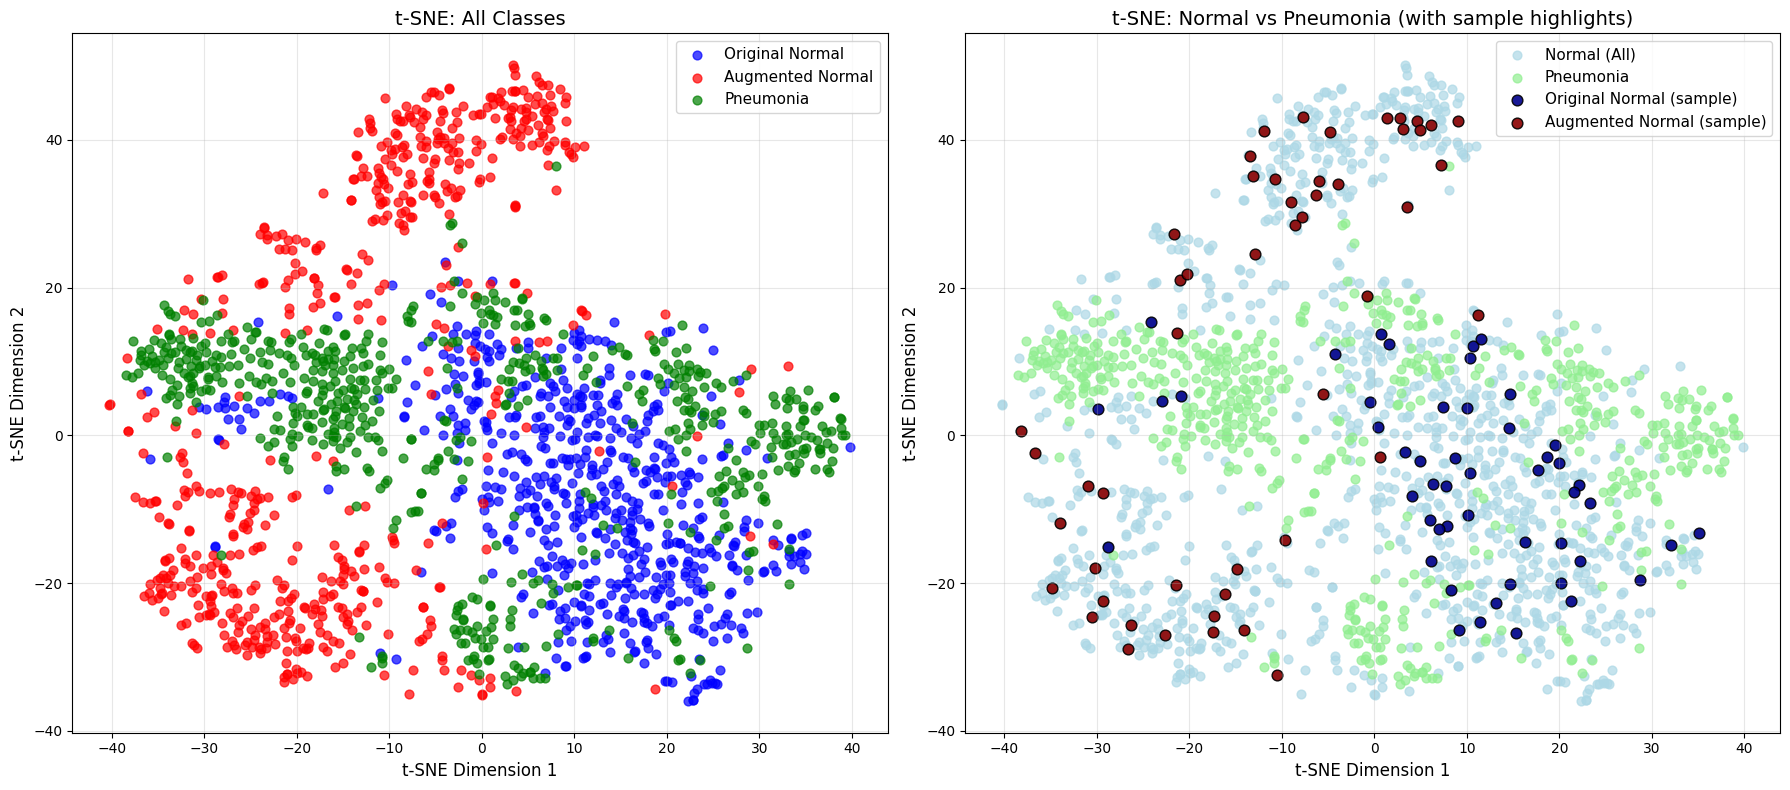


INTERPRETATION GUIDE:
1. Good augmentation: Original and Augmented Normal points should overlap
2. Class separation: Normal and Pneumonia should form distinct clusters
3. Silhouette Score: Higher values (closer to 1) indicate better clustering
4. Calinski-Harabasz: Higher values indicate better defined clusters
⚠️ Classes may not be well separated in feature space


In [12]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def enhanced_tsne_visualization(normal_path, pneumonia_path, sample_size=600):
    """Enhanced t-SNE visualization with cluster analysis"""
    features = []
    labels = []  # 0 = Original Normal, 1 = Augmented Normal, 2 = Pneumonia
    label_names = ['Original Normal', 'Augmented Normal', 'Pneumonia']
    
    # Collect features from all three categories
    for i, (path, is_augmented, label_val) in enumerate([
        (normal_path, False, 0),      # Original Normal
        (normal_path, True, 1),       # Augmented Normal  
        (pneumonia_path, False, 2)    # Pneumonia
    ]):
        if is_augmented:
            files = [f for f in os.listdir(path) 
                    if f.startswith('aug') and f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        else:
            files = [f for f in os.listdir(path) 
                    if not f.startswith('aug') and f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Take a sample
        if len(files) > sample_size:
            files = np.random.choice(files, sample_size, replace=False)
        
        for img_file in files:
            img_path = os.path.join(path, img_file)
            try:
                img = load_img(img_path, target_size=(128, 128))
                img_array = img_to_array(img) / 255.0
                features.append(img_array.flatten())
                labels.append(label_val)
            except Exception as e:
                print(f"Skipping {img_file} due to error: {str(e)}")
                continue
    
    features = np.array(features)
    labels = np.array(labels)
    
    print(f"Dataset size: {features.shape[0]} images")
    print(f"Class distribution: {np.bincount(labels)}")
    
    # Dimensionality reduction with PCA
    pca = PCA(n_components=min(50, features.shape[0]))
    features_pca = pca.fit_transform(features)
    print(f"PCA explained variance: {np.sum(pca.explained_variance_ratio_):.3f}")
    
    # t-SNE visualization - FIXED: changed n_iter to max_iter
    tsne = TSNE(n_components=2, random_state=42, perplexity=40, max_iter=1500)
    features_tsne = tsne.fit_transform(features_pca)
    
    # Calculate cluster metrics
    silhouette = silhouette_score(features_tsne, labels)
    ch_score = calinski_harabasz_score(features_tsne, labels)
    
    print(f"Silhouette Score: {silhouette:.3f}")
    print(f"Calinski-Harabasz Score: {ch_score:.3f}")
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Plot 1: All points
    colors = ['blue', 'red', 'green']
    for i, label_name in enumerate(label_names):
        mask = labels == i
        ax1.scatter(features_tsne[mask, 0], features_tsne[mask, 1], 
                   c=colors[i], alpha=0.7, label=label_name, s=40)
    
    ax1.set_title('t-SNE: All Classes', fontsize=14)
    ax1.set_xlabel('t-SNE Dimension 1', fontsize=12)
    ax1.set_ylabel('t-SNE Dimension 2', fontsize=12)
    ax1.legend(fontsize=11)
    ax1.grid(alpha=0.3)
    
    # Plot 2: Focus on Normal vs Augmented comparison
    normal_mask = labels <= 1  # Only Original and Augmented Normal
    pneumonia_mask = labels == 2  # Only Pneumonia
    
    ax2.scatter(features_tsne[normal_mask, 0], features_tsne[normal_mask, 1], 
               c='lightblue', alpha=0.7, label='Normal (All)', s=40)
    ax2.scatter(features_tsne[pneumonia_mask, 0], features_tsne[pneumonia_mask, 1], 
               c='lightgreen', alpha=0.7, label='Pneumonia', s=40)
    
    # Highlight a few points from each normal category
    original_normal_indices = np.where(labels == 0)[0]
    augmented_normal_indices = np.where(labels == 1)[0]
    
    if len(original_normal_indices) > 0 and len(augmented_normal_indices) > 0:
        # Take samples if available
        original_sample_size = min(50, len(original_normal_indices))
        augmented_sample_size = min(50, len(augmented_normal_indices))
        
        original_normal_idx = original_normal_indices[:original_sample_size]
        augmented_normal_idx = augmented_normal_indices[:augmented_sample_size]
        
        ax2.scatter(features_tsne[original_normal_idx, 0], features_tsne[original_normal_idx, 1], 
                   c='darkblue', alpha=0.9, label='Original Normal (sample)', s=60, edgecolors='black')
        ax2.scatter(features_tsne[augmented_normal_idx, 0], features_tsne[augmented_normal_idx, 1], 
                   c='darkred', alpha=0.9, label='Augmented Normal (sample)', s=60, edgecolors='black')
    
    ax2.set_title('t-SNE: Normal vs Pneumonia (with sample highlights)', fontsize=14)
    ax2.set_xlabel('t-SNE Dimension 1', fontsize=12)
    ax2.set_ylabel('t-SNE Dimension 2', fontsize=12)
    ax2.legend(fontsize=11)
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Interpret the results
    print("\n" + "="*60)
    print("INTERPRETATION GUIDE:")
    print("="*60)
    print("1. Good augmentation: Original and Augmented Normal points should overlap")
    print("2. Class separation: Normal and Pneumonia should form distinct clusters")
    print("3. Silhouette Score: Higher values (closer to 1) indicate better clustering")
    print("4. Calinski-Harabasz: Higher values indicate better defined clusters")
    
    if silhouette > 0.5:
        print("✓ Good cluster separation between classes")
    else:
        print("⚠️ Classes may not be well separated in feature space")
    
    return features_tsne, labels

# Run the enhanced visualization
features_tsne, labels = enhanced_tsne_visualization(normal_path, pneumonia_path)